In [251]:
import pandas as pd
import numpy as np
import warnings


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from catboost import CatBoostClassifier


warnings.filterwarnings(action="ignore")

In [2]:
train_avito_data = pd.read_csv("data/train.csv")

In [3]:
val_avito_data = pd.read_csv("data/val.csv")

# Подготовка данных

1) выделим параметры `phone_number_NOT_given_with_digits`, `contains_phone_number`, `contains_link`, `contains_vk`, `contains_fb`, `contains_instagram`. Затем сохраним те, которые будут соответствовать фродовому случаю.

2) По-моему мнению, в контексте авито, чтобы не портить опыт пользователей продавцов (которые приносят основный доход) в нашем случае лучше недоловить фродстеров (мошенников), чем переловить даже неважные кейсы. Другими словами помечать только те кейсы, где есть явный паттерн нарушения.


In [270]:
# для подсчета цифр в тексте
def count_digits(string):
    return sum(item.isdigit() for item in string)

def prepare_data(train_data=None, val_data=None):
    
    if train_data is not None and val_data is None:
        df = train_data.copy()
    if val_data is not None and train_data is not None:
        df = val_data.copy()
    
    # т.к. мы знаем, что в val данные достаточно точные, поэтому трогать мы их не будем
    # а в train обязательно будем
    if train_data is not None and val_data is None:
        fraud = df[df["is_bad"]==1].copy()
        
        fraud["description_title"] = fraud["description"] + " " + fraud["title"]
        
        fraud["#_of_digits"] = fraud["description_title"].apply(count_digits)

        # цифрами точно не передан номер, с учетом домашнего телефона
        fraud["phone_number_NOT_given_with_digits"] = fraud["#_of_digits"] < 6
        
        # слова-цифры
        words_numbers = ["ноль","один","два", "три", "четыре", "пять", "шесть", "семь","девять", "десять",
                    "одиннадцать", "двеннадцать", "триннадцать", "четырнадцать", "пятнадцать", "шесть"
                    "шестнадцать","семнадцать","восемнадцать","девятнадцать","двадцать","тридцать",
                    "сорок","пятьдесят","шестьдесят","семьдесят","восемьдесят","девяносто",
                    "сто","двести","триста","четыреста","пятьсот","шестьсот","семьсот","восемьсот","девятьсот"]

        fraud["contains_word_number"] = fraud["description_title"].apply(lambda x: \
                                    any(word_number in x for word_number in words_numbers))
        
        fraud["contains_link"] = fraud["description_title"].str.contains("https://") |\
                                fraud["description_title"].str.contains(".ru")

        fraud["contains_vk"] = fraud["description_title"].str.contains("vk") | \
                                fraud["description_title"].str.contains("вконтакте") | \
                                fraud["description_title"].str.contains("в контакте")

        fraud["contains_inst"] = fraud["description_title"].str.contains("instagram") | \
                                fraud["description_title"].str.contains("инстагр")

        fraud["contains_fb"] = fraud["description_title"].str.contains("facebook") | \
                                fraud["description_title"].str.contains("фейсбук")


        # точные кейсы, где содержится номер телефона
        fraud["contains_phone_number"] = fraud["description_title"]\
                                    .str.contains("^((8|\+7)[\- ]?)?(\(?\d{3}\)?[\- ]?)?[\d\- ]{7,10}$") 

        developed_fraud = fraud.query("phone_number_NOT_given_with_digits == False or contains_word_number == True or \
                contains_link == True or contains_vk == True or contains_inst == True or \
                contains_fb == True or contains_phone_number==True").copy()

        df.loc[df.index.isin(developed_fraud.index), "fraud_developed"] = 1
        df.loc[~(df.index.isin(developed_fraud.index)), "fraud_developed"] = 0
        
        # вернем старое название
        df = df.drop("is_bad", axis=1).rename(columns={"fraud_developed": "is_bad"})
    
    # уберем явных аутлаеров в категории цены, чтобы они не испортили замену на средние значения
    df = df[np.abs(df.price-df.price.mean()) <= (3*df.price.std())]
    
    # обработка пропущенных значени в price (есть пропущенные в обоих train и val)
    df["price"] = df.loc[:,"price"].fillna(df.groupby("subcategory")["price"]\
                               .transform("mean"))
    
    # стандартизируем показатель цены
    #df["price"]=(df["price"]-df["price"].mean())/df["price"].std()
    
    # добавим вспомогательные, простые параметры текста title, description для модели
    df["description_len"] = df["description"].apply(len)
    df["title_len"] = df["title"].apply(len)
    df["number_of_words_description"] = df["description"].apply(lambda x: len(x.split(" ")))
    df["number_of_words_title"] = df["title"].apply(lambda x: len(x.split(" ")))
    df["number_of_sentences_description"] = df["description"].apply(lambda x: x.count(".")+\
                                                                    x.count("!")+x.count("?"))
    
    #подготовка данных к модели
    # отдельный eda показал, что category малозначимый параметр для определения класса, 
    # поэтому его мы уберем сразу на этапе подготовки данных
    df = df[["subcategory", "price", "region", \
            "city", "is_bad", "description_len", "title_len",
            "number_of_words_description", "number_of_words_title", "number_of_sentences_description"]]
    
    
    #label encoding для 'subcategory', 'region', 'city' (эти показатели остояли свою важность)
    object_cols = ['subcategory', 'region', 'city']
    
    # важно, чтобы label encoding из train полностью соответствовал validate
    if val_data is not None and train_data is not None:
        label_encoder_subcategory = LabelEncoder()
        label_encoder_region = LabelEncoder()
        label_encoder_city = LabelEncoder()
        
        label_encoder_subcategory.fit(train_data["subcategory"])
        label_encoder_region.fit(train_data["region"])
        label_encoder_city.fit(train_data["city"])
        
        df["subcategory"] = label_encoder_subcategory.transform(df["subcategory"])
        df["region"] = label_encoder_region.transform(df["region"])
        df["city"] = label_encoder_city.transform(df["city"])
    
    if train_data is not None and val_data is None:
        label_encoder = LabelEncoder()
        for col in object_cols:
            df[col] = label_encoder.fit_transform(df[col])
        
    return df

In [1]:
#TODO: 1. добавить показатель почты contains "mail, почта"
#TODO: 2. сделать str.lower description, когда будешь искать слова тригеры
#TODO: 3. объединить свои метрики для отчистки фрода в один показатель

# чистовик

In [271]:
train_data = prepare_data(train_avito_data)

In [272]:
X_train = train_data.drop("is_bad", axis=1).copy()
y_train = train_data.is_bad.copy()

In [273]:
val_data = prepare_data(train_avito_data, val_avito_data)

In [274]:
X_val = val_data.drop("is_bad", axis=1).copy()
y_val = val_data.is_bad.copy()

# выбор данных для обучения и выбор модели классификации


- т.к. данные сильно несбалансированы, то стоит сделать undersampling
- за базовую модель возьем catboost
- найдем наилучшие параметры с помощью gridsearch

In [ ]:
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

## Feature selection

важность в валид выборке:

In [279]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=9)

fit = bestfeatures.fit(X_val, y_val)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_val.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

featureScores.columns = ['Specs','Score']  #naming the dataframe columns

featureScores.sort_values("Score", ascending=False)  #print 10 best features

,Specs,Score
1,price,2.232550e+08
4,description_len,7.961180e+05
6,number_of_words_description,9.149893e+04
3,city,2.657646e+04
8,number_of_sentences_description,1.095477e+04
5,title_len,4.032815e+03
0,subcategory,3.466630e+03
2,region,2.304468e+03
7,number_of_words_title,2.753954e+02


важность в трэйн выборке

In [280]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=9)

fit = bestfeatures.fit(X_train, y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.sort_values("Score", ascending=False)

,Specs,Score
1,price,2.906415e+10
4,description_len,6.601337e+06
6,number_of_words_description,8.015295e+05
3,city,5.225109e+05
8,number_of_sentences_description,7.316470e+04
5,title_len,5.726426e+04
0,subcategory,4.726078e+04
2,region,2.379094e+04
7,number_of_words_title,3.049544e+03


- важность параметров в валид

[0.15629667 0.09111886 0.11757632 0.09991651 0.15748314 0.11340715
 0.11666542 0.06749682 0.08003912]


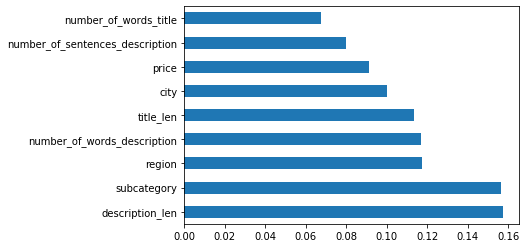

In [276]:
import pandas as pd
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X_val, y_val)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization

feat_importances = pd.Series(model.feature_importances_, index=X_val.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [76]:
columns_1 = ["subcategory", "number_of_words_title", "price", "number_of_sentences_description",
            "city", "region", "title_len", "number_of_words_description", "description_len"]

- Как можно заметить, наши вспомогательные метрики здорово помогают определять класс фрода. На последних местах one hot encoding от `category`. Заберем самые важные параметры

In [283]:
model = CatBoostClassifier(random_state=1, 
                           iterations=100,
                           learning_rate=0.2,
                           depth=6)

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_val)

0:	learn: 0.6716551	total: 163ms	remaining: 16.1s
1:	learn: 0.6545570	total: 264ms	remaining: 12.9s
2:	learn: 0.6422939	total: 339ms	remaining: 10.9s
3:	learn: 0.6328142	total: 452ms	remaining: 10.9s
4:	learn: 0.6262822	total: 529ms	remaining: 10.1s
5:	learn: 0.6201751	total: 627ms	remaining: 9.82s
6:	learn: 0.6136244	total: 726ms	remaining: 9.64s
7:	learn: 0.6092818	total: 796ms	remaining: 9.15s
8:	learn: 0.6054297	total: 882ms	remaining: 8.92s
9:	learn: 0.6023500	total: 961ms	remaining: 8.65s
10:	learn: 0.6000347	total: 1.03s	remaining: 8.34s
11:	learn: 0.5969982	total: 1.12s	remaining: 8.19s
12:	learn: 0.5947613	total: 1.22s	remaining: 8.18s
13:	learn: 0.5931837	total: 1.31s	remaining: 8.03s
14:	learn: 0.5902367	total: 1.39s	remaining: 7.85s
15:	learn: 0.5886088	total: 1.51s	remaining: 7.96s
16:	learn: 0.5874409	total: 1.61s	remaining: 7.87s
17:	learn: 0.5860335	total: 1.76s	remaining: 8.02s
18:	learn: 0.5842510	total: 1.86s	remaining: 7.92s
19:	learn: 0.5829092	total: 1.92s	remaini

In [284]:
roc_auc_score(y_pred, y_val)

0.7170083350453438

In [281]:
# from sklearn.externals import joblib

# joblib.dump(model, "avito_model_78%.pkl")

['avito_model_78%.pkl']

In [286]:
# train_data.to_pickle("train_data.p")

In [ ]:
# train_avito_data.to_pickle("train_avito_data.p", compression="gzip")

In [11]:
# grid = {'depth':[1, 3, 5, 9],
#           'iterations':[250, 500, 1000],
#           'learning_rate':[0.01,0.1,0.3], 
#           'l2_leaf_reg':[1,5,10,100],
#         }



# model = CatBoostClassifier(random_state=rand, loss_function='Logloss')

# grid_search_result = model.grid_search(grid, 
#                                            X = X_resampled, 
#                                            y = y_resampled, verbose=10)

# Results from Random Search
# print("\n========================================================")
# print(f" Results from Random Search of random state - {rand}" )
# print("========================================================")    

# print("\n The best estimator across ALL searched params:\n",
#               grid_search_result.best_estimator_)
# print("\n The best score across ALL searched params:\n",
#               grid_search_result.best_score_)

# print("\n The best parameters across ALL searched params:\n",
#               grid_search_result.best_params_)
    
# y_pred = grid_search_result.best_estimator_.predict(X_val)
    
#     print(f"\n The AUC SSCORE FOR VALIDAETION SET for random state {rand}:\n",
#               roc_auc_score(y_pred, y_val))

#     print("\n ========================================================")